In [1]:
import pandas as pd
import os 

# Visualise The Lables from the csv file

In [2]:
face_df = pd.read_csv('./datasets/cartoon_set/labels.csv')
face_df = face_df.drop('Unnamed: 0', axis = 1)
face_df.head()

,eye_color,face_shape,file_name
0,1,4,0.png
1,2,4,1.png
2,2,3,2.png
3,2,0,3.png
4,0,2,4.png


In [3]:
face_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   eye_color   10000 non-null  int64 
 1   face_shape  10000 non-null  int64 
 2   file_name   10000 non-null  object
dtypes: int64(2), object(1)
memory usage: 234.5+ KB


In [4]:
face_df.isnull().sum()

eye_color     0
face_shape    0
file_name     0
dtype: int64

In [35]:
face_df.value_counts('eye_color')

eye_color
1    2018
4    2017
0    2004
3    1992
2    1969
dtype: int64

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.io import imread, imshow

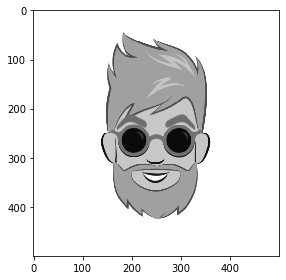

In [7]:
image = imread('./datasets/cartoon_set/img/0.png', as_gray = True)
imshow(image);

# Test

In [11]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
import os
import numpy as np
from keras.preprocessing import image
import cv2
import dlib

Using TensorFlow backend.
/opt/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/python36/lib/pytho

In [12]:
# PATH TO ALL IMAGES
global basedir, image_paths, target_size
basedir = './datasets/cartoon_set'
images_dir = os.path.join(basedir,'img')
labels_filename = 'labels.csv'

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [13]:
def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((shape.num_parts, 2), dtype=dtype)

    # loop over all facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords

In [14]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    # return a tuple of (x, y, w, h)
    return (x, y, w, h)


In [15]:
def run_dlib_shape(image):
    # in this function we load the image, detect the landmarks of the face, and then return the image and the landmarks
    # load the input image, resize it, and convert it to grayscale
    resized_image = image.astype('uint8')

    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    gray = gray.astype('uint8')

    # detect faces in the grayscale image
    rects = detector(gray, 1)
    num_faces = len(rects)

    if num_faces == 0:
        return None, resized_image

    face_areas = np.zeros((1, num_faces))
    face_shapes = np.zeros((136, num_faces), dtype=np.int64)

    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        temp_shape = predictor(gray, rect)
        temp_shape = shape_to_np(temp_shape)

        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)],
        #   (x, y, w, h) = face_utils.rect_to_bb(rect)
        (x, y, w, h) = rect_to_bb(rect)
        face_shapes[:, i] = np.reshape(temp_shape, [136])
        face_areas[0, i] = w * h
    # find largest face and keep
    dlibout = np.reshape(np.transpose(face_shapes[:, np.argmax(face_areas)]), [68, 2])

    return dlibout, resized_image

In [16]:
def extract_features_labels():
    
    image_paths = [os.path.join(images_dir, l) for l in os.listdir(images_dir)]
    target_size = None
    labels_file = open(os.path.join(basedir, labels_filename), 'r')
    lines = labels_file.readlines()
    face_labels = {line.split(',')[0] : int(line.split(',')[2]) for line in lines[1:]}
    if os.path.isdir(images_dir):
        all_features = []
        all_labels = []
        for img_path in image_paths:
            
            file_name= img_path.split('.')[1].split('/')[-1]
            

                    # load image
            img = image.img_to_array(image.load_img(img_path,target_size=target_size,interpolation='bicubic'))
            features, _ = run_dlib_shape(img)
            if features is not None:
                all_features.append(features)
                all_labels.append(face_labels[file_name])

    landmark_features = np.array(all_features)
    face_labels = np.array(all_labels) 
    return landmark_features, face_labels

In [17]:
def get_data():

    X, y = extract_features_labels()
    Y = np.array([y, -(y - 1)]).T
    tr_X = X[:7000]
    tr_Y = Y[:7000]
    te_X = X[7000:]
    te_Y = Y[7000:]

    return tr_X, tr_Y, te_X, te_Y

In [18]:
tr_X, tr_Y, te_X, te_Y= get_data()

In [22]:
tr_X.shape, te_X.shape

((7000, 68, 2), (815, 68, 2))

# Linear SVC

In [20]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn import svm

In [23]:
def img_SVM(training_images, training_labels, test_images, test_labels):
    classifier = svm.SVC(kernel = 'linear')
    classifier.fit(training_images, training_labels)
    pred = classifier.predict(test_images)
    print("Accuracy:", accuracy_score(test_labels, pred))

    print(pred)
    return pred

pred=img_SVM(tr_X.reshape((7000, 68*2)), list(zip(*tr_Y))[0], te_X.reshape((815, 68*2)), list(zip(*te_Y))[0])
#pred=img_SVM(tr_X, list(zip(*tr_Y))[0], te_X, list(zip(*te_Y))[0])

Accuracy: 0.7398773006134969
[1 3 0 0 4 4 0 3 1 4 0 4 3 3 2 4 3 3 0 3 1 3 2 1 0 2 2 1 2 3 2 4 1 2 2 2 2
 3 2 3 2 3 0 4 3 2 0 0 0 4 4 0 3 2 2 1 3 4 2 2 4 2 4 3 2 4 2 1 1 4 2 1 2 4
 1 0 1 1 2 4 0 0 2 2 2 0 3 1 0 4 4 4 1 0 0 4 3 2 2 3 0 4 0 4 0 4 0 0 1 3 3
 3 0 3 1 3 2 2 3 4 4 0 2 2 2 0 3 1 4 0 4 3 3 0 3 4 0 2 3 3 4 0 4 1 2 0 0 2
 2 1 2 3 2 1 1 0 1 4 1 2 3 0 2 2 0 0 0 1 2 1 2 0 2 1 0 0 3 4 2 2 4 3 2 4 0
 3 2 2 2 0 3 1 0 4 1 3 4 4 2 3 2 0 1 2 2 0 3 4 2 3 2 0 0 2 2 4 0 3 2 4 3 4
 1 1 3 2 0 1 4 4 1 1 1 0 1 0 1 0 0 1 3 1 1 1 3 4 4 0 1 2 2 3 4 2 1 3 4 3 4
 4 1 1 2 2 0 0 1 1 0 3 0 4 0 1 0 3 2 4 3 3 3 0 4 3 4 0 1 1 3 4 0 2 4 4 4 2
 4 0 2 3 1 3 3 3 2 1 3 0 1 3 4 3 4 4 3 1 0 4 0 3 2 0 4 4 3 3 4 2 3 2 3 2 4
 4 1 1 2 0 0 0 1 2 2 0 3 2 0 0 4 0 2 0 2 1 1 2 1 0 4 2 2 4 3 3 4 2 2 4 4 3
 4 2 0 0 0 4 3 2 3 2 3 3 1 0 0 2 4 3 1 0 0 3 0 2 1 2 1 3 4 3 4 1 1 3 2 3 2
 2 0 2 1 3 4 4 2 2 3 3 4 2 1 0 3 1 4 2 4 0 4 0 3 0 3 1 4 0 2 0 2 1 0 1 0 1
 0 0 1 3 4 3 1 2 3 0 4 0 3 2 0 3 1 0 3 3 2 4 0 3 3 4 2 1 2 1 2 2 2 4 4 

# K-Neighbors Classifier

## Import Libraries

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [25]:
X, y = extract_features_labels()

In [26]:
X.shape, y.shape

((7815, 68, 2), (7815,))

In [27]:
X = X.reshape(7815,68*2)
X.shape

(7815, 136)

Split dataset

In [28]:
X_train, X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=3)

In [29]:
print('train set: {}  | test set: {}'.format(round(((len(y_train)*1.0)/len(X)),3), round((len(y_test)*1.0)/len(X),3)))

train set: 0.7  | test set: 0.3


In [30]:
X_train.shape, y_train.shape, y_train

((5470, 136), (5470,), array([0, 1, 0, ..., 2, 4, 1]))

Create a function to run a K-Neighbours Classifier using scikit learn library

In [33]:
def KNNClassifier(X_train, y_train, X_test,k):

    #Create KNN object with a K coefficient
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train) # Fit KNN model


    Y_pred = neigh.predict(X_test)
    return Y_pred




Y_pred =KNNClassifier(X_train, y_train, X_test,4)
  

score=metrics.accuracy_score(y_test,Y_pred)
print(score)

0.5104477611940299
